In [21]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout
import matplotlib.pyplot as plt
import numpy as np
from models.vae import VAE
import torch
import random
import yaml
from models.vrnn import VRNN_OLD

# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test = 'vrnn'

if test == 'vae':
    V_model = VAE(img_channels=1, latent_size=32).to(device)
    V_model.load_state_dict(torch.load('saved_models/vae-mdrnn/vae_moving_digits_beta_5.pt'))
    V_model.eval()
else :
    model_path = 'saved_models/model_vrnn_2023-02-24.pt'
    params_path_recovery = model_path[:-3]+'.params.yml'
    with open(params_path_recovery) as file :
        parameters = yaml.load(file,Loader=yaml.FullLoader)
    V_model = VRNN_OLD(img_size=parameters['img_size'],
                    hidden_dim=parameters['hidden_dim'],
                    latent_dim=parameters['latent_dim'],
                    RNN_dim=parameters['RNN_dim']).to(device)
    V_model.load_state_dict(torch.load(model_path))
    V_model.eval()
print(device)

cuda


In [22]:
# import data from the moving mnist dataset
data_sequential = np.load('data/bouncing_mnist_test.npy')
data_sequential = data_sequential / 255
data = data_sequential.reshape((200000,1,64,64))

x.shape torch.Size([1, 1, 64, 64])
z_mean.shape torch.Size([1, 1, 32])


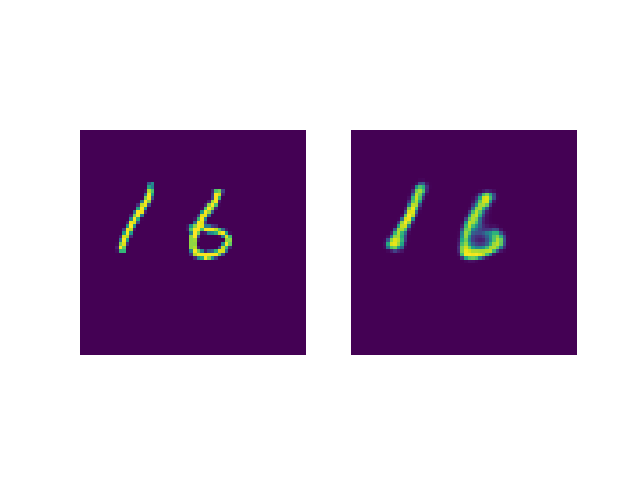

In [34]:
# we sample a random frame as a starting point of the latent space visualization
sample = random.sample(list(data), 1)
imgs = torch.tensor(sample)
imgs = imgs.to(device).float()
img = np.transpose(imgs[0].cpu().detach().numpy(), [1,2,0])
mu, logsigma = V_model.encoder_pass(imgs)
out = V_model.decoder_pass(mu)
outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])

plt.figure()
plt.subplot(121)
plt.imshow(np.squeeze(img))
plt.axis('off')
plt.subplot(122)
plt.imshow(np.squeeze(outimg))
plt.axis('off')
plt.show()

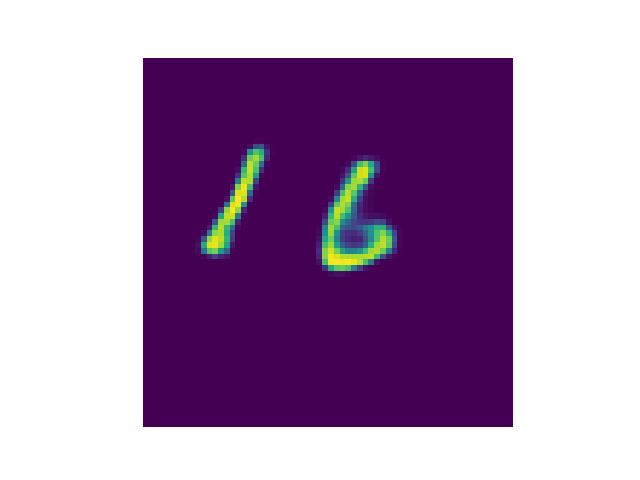

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = V_model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = 32
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))

AttributeError: 'VAE' object has no attribute 'rnn'

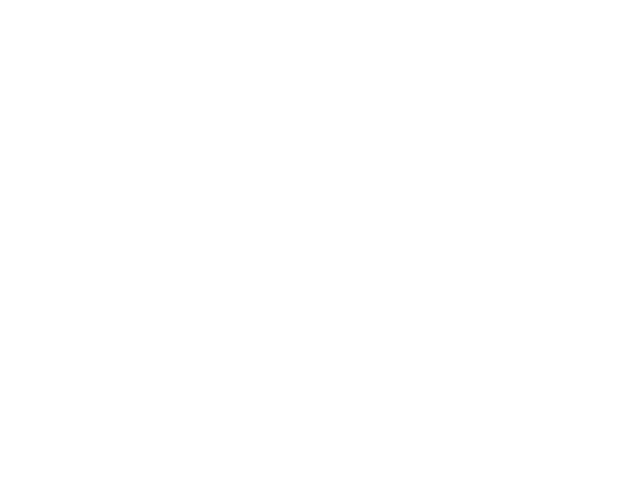

In [15]:
plt.figure()
plt.imshow(V_model.rnn.weight_hh_l0.cpu().detach().numpy())
plt.show()

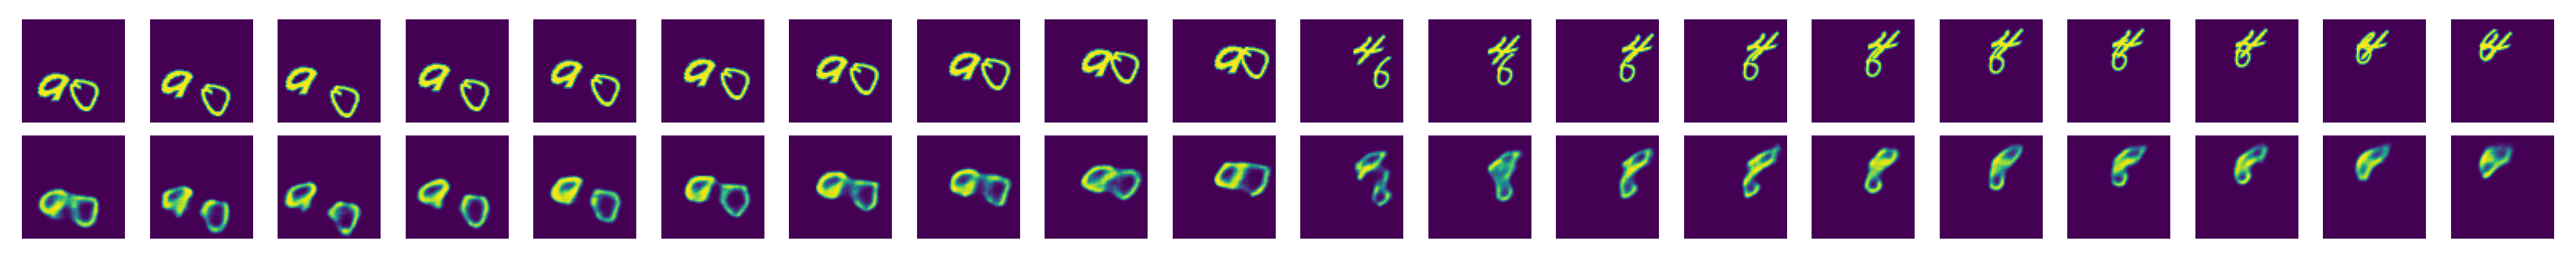

In [39]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

# import data from the moving mnist dataset
data = np.load('data/bouncing_mnist_test.npy')

# normalize the data to be between 0 and 1 (better training performance for some reason)
data = data / 255

data.shape

def plot_video_comparison(video,reconstructed_video):
    fig,ax = plt.subplots(2,20,figsize=(20,2))
    for i in range(20):
        ax[0,i].imshow(video[i,:,:])
        ax[0,i].axis('off')
    for i in range(20):
        ax[1,i].imshow(reconstructed_video[i,:,:])
        ax[1,i].axis('off')
    fig.tight_layout()

random_index = np.random.randint(1000)
sample = data[random_index]
sample = np.concatenate((data[random_index][:10],np.flip(data[random_index+1][:10],axis=0)))
sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
y, mean, logvar, mean_prior, logvar_prior, z = V_model.forward(sample_tensor)
reconstructed_sample = y.cpu().detach().numpy().reshape((20,64,64))


plot_video_comparison(sample,reconstructed_sample)

In [41]:
var_posterior = np.exp(logvar.cpu().detach().numpy().reshape((20,32)))
var_prior = np.exp(logvar_prior.cpu().detach().numpy().reshape((20,32)))
latent_var = z.cpu().detach().numpy().reshape((20,32))


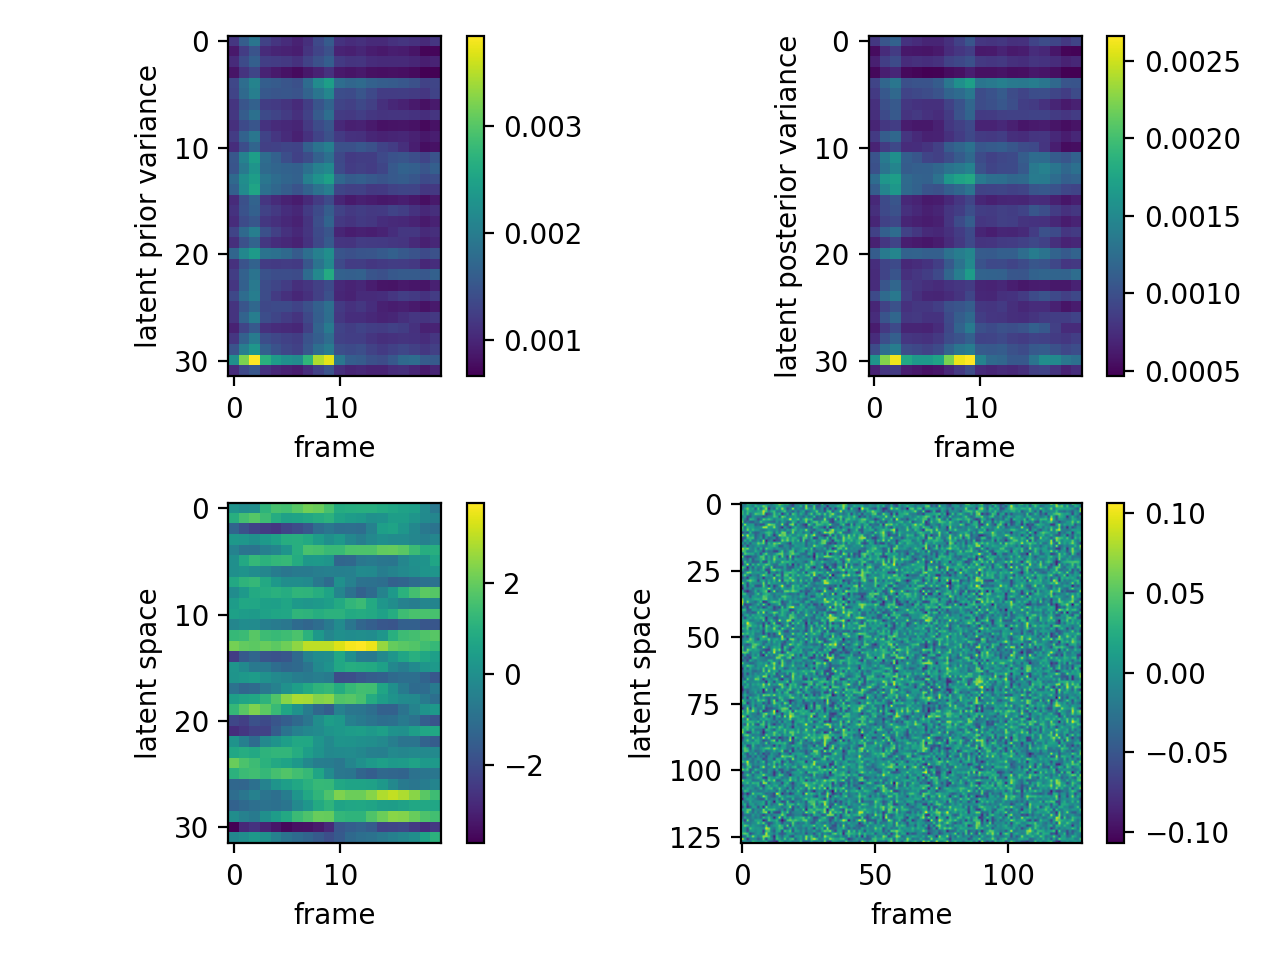

In [43]:
plt.figure()

plt.subplot(221)
plt.imshow(var_prior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prior variance')

plt.subplot(222)
plt.imshow(var_posterior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent posterior variance')

plt.subplot(223)
plt.imshow(latent_var.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.subplot(224)
plt.imshow(V_model.rnn.weight_hh_l0.cpu().detach().numpy())
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.tight_layout()
plt.show()